In [1]:
# Setup

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.optimize import root as sp_root

from utils.solvers import FirstOrderDiffEqn
from utils.solvers.firstorder import num_sol_runge_kutta,num_sol_euler
from utils.plot.utils import draw_circle, draw_arrow

plt.rcParams["figure.figsize"] = (20, 20)

def saveFig(filename, chapter):
  plt.savefig(f"plots/chapter{chapter}/{filename}.png", facecolor="w")

# Chapter 5 - Linear Systems

The simplest two-dimensional system is a linear system, defined by
$$
\begin{equation}
\dot{\mathbf{x}} = A\mathbf{x}
\end{equation}
$$
Where $A = \begin{pmatrix} a & b \\ c & d \end{pmatrix}$ and $\mathbf{x} = \begin{pmatrix} x \\ y \end{pmatrix}$

- Linear in the sense that linear superposition of solutions is itself a solution
- Consider solutions with straight-line trajectories, will have form $\mathbf{x}(t) = e^{\lambda t}\mathbf{v}$ where $\lambda \in \mathbb{C}$ and $\mathbf{v}$ is some constant vector
  - Implies $Ae^{\lambda t}\mathbf{v} = A\mathbf{x} = \dot{\mathbf{x}} = \lambda e^{\lambda t}\mathbf{v} \implies A\mathbf{v} = \lambda\mathbf{v}$
  - Eigenvalue problem, solutions form an eigenbasis for the solution space

$$
\begin{equation}
  \begin{vmatrix}
    a - \lambda & b \\
    c & d - \lambda
  \end{vmatrix} = 0 \implies \lambda^2 - (a + d)\lambda + ad - bc = 0 \implies \lambda = \frac{a + d \pm \sqrt{(a + d)^2 - 4(ad - bc)}}{2}
\end{equation}
$$
Letting $\Delta = \text{det}(A) = ad - bc$ and $\tau = \text{tr}(A) = a + d$, then $\lambda = \frac{\tau \pm \sqrt{\tau^2 - 4\Delta}}{2}$

- In general defines two eigenvectors
- For initial condition $\mathbf{x}(0) = c_1\mathbf{v_1} + c_2\mathbf{v_2}$, a solution is $\mathbf{x}(t) = c_1e^{\lambda_1 t}\mathbf{v_1} + c_2e^{\lambda_2 t}\mathbf{v_2}$ as it is a linear combination of solutions, and by the uniqueness theorem this is the only solution
- For real solutions, will eventually by asymptotic to the slower decaying eigendirection

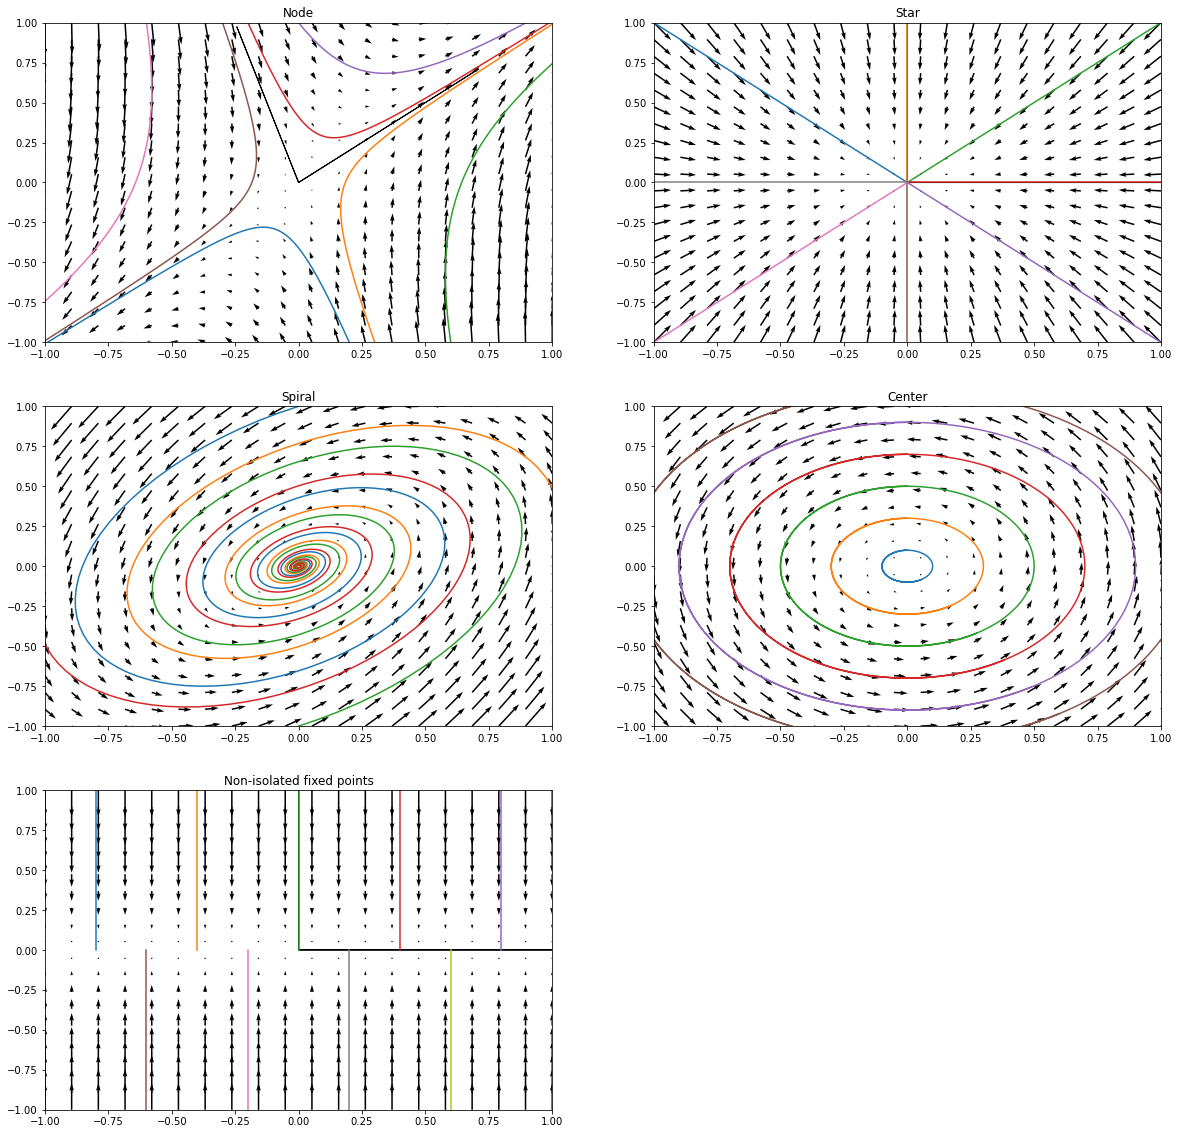

In [157]:
As = [
  (np.array([[1, 1], [4, -2]]), "Node", [[0.2, -1], [0.3, -1], [0.6, -1], [-0.2, 1], [0, 1], [-0.3, 1], [-0.6, 1]]),
  (np.array([[-1, 0], [0, -1]]), "Star", [[-1, 1], [0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1], [-1, 0]]),
  (np.array([[1, -4], [4, -2]]), "Spiral", [[0, 1], [1, 0], [0, -1], [-1, 0]]),
  (np.array([[0, -1], [1, 0]]), "Center", [[0, 0.1], [0, 0.3], [0, 0.5], [0, 0.7], [0, 0.9], [0, 1.1]]),
  (np.array([[0, 0], [0, -1]]), "Non-isolated fixed points", [[-0.8, 1], [-0.4, 1], [-0, 1], [0.4, 1], [0.8, 1], [-0.6, -1], [-0.2, -1], [0.2, -1], [0.6, -1]]),
]

coords = np.linspace(-1, 1, 20)
X, Y = np.meshgrid(coords, coords)

def get_eigenbasis_transform_matrix(egvec1, egvec2):
  return np.array([[egvec2[1], -egvec2[0]], [-egvec1[1], egvec1[0]]]) / (egvec1[0] * egvec2[1] - egvec1[1] * egvec2[0])

def transform_to_eigenbasis(v, R):
  return np.dot(R, v)

def transform_from_eigenbasis(v, R):
  return np.dot(np.linalg.inv(R), v)

for idx, (A, title, trajectory_initial_coords) in enumerate(As, start=1):
  (egval1, egval2), egvecs = linalg.eig(A)
  egvec1, egvec2 = egvecs.T
  R = get_eigenbasis_transform_matrix(egvec1, egvec2)

  U, V = np.array([np.dot(np.linalg.inv(R), np.array([egval1, egval2]).T * np.dot(R, [x, y])) for y in coords for x in coords]).reshape([-1, 2]).T

  plt.subplot(3, 2, idx)
  plt.title(title)
  plt.gca().set_xlim([-1, 1])
  plt.gca().set_ylim([-1, 1])

  plt.quiver(X, Y, U, V)

  for v0 in trajectory_initial_coords:
    vs = np.array([transform_from_eigenbasis(transform_to_eigenbasis(v0, R) * [np.exp(egval1 * t), np.exp(egval2 * t)], R).real for t in np.linspace(0, 10, 500)])
    plt.plot(vs[:, 0], vs[:, 1])

  if(all(egvec1.imag == 0) and all(egvec2.imag == 0)):
    plt.arrow(0, 0, egvec1[0], egvec1[1])
    plt.arrow(0, 0, egvec2[0], egvec2[1])

- In the eigenbasis $\Delta = \lambda_1\lambda_2$ and $\tau = \lambda_1 + \lambda_2$, as these are geometric quantities these are identities in all coordinate systems
- There are several types of solutions to these systems:
  - **Node**: $\tau^2 - 4\Delta > 0$ so there are only real eigenvalues (**Stable** if direction is towards the node, **unstable** otherwise)
  - **Spirals**: $\tau^2 - 4\Delta < 0$ so the exponent is complex leading to a 2D rotation (**Stable** if trajectory decays towards center, **unstable** otherwise)
    - **Center**: If $\tau = 0$ and $-4\Delta < 0$ then the exponent is imaginary, so there will only be rotational motion
  - **Degenerate node**: $\tau^2 - 4\Delta = 0$ so there is only one eigenvalue and thus one eigendirection, essentially the limit of a normal node when the eigendirections converge
    - **Star**: $A = \lambda I$ so there is one eigenvalue but two eigenvectors, will just scale vectors so all phase points will move towards/away from center in a straight line
  - **Non-isolated fixed points**: $\Delta = 0$, then $\lambda \in \{0, \tau\}$, so all phase points will move parallel to one eigendirection and perpendicular to the other leading to an infinite number of fixed points

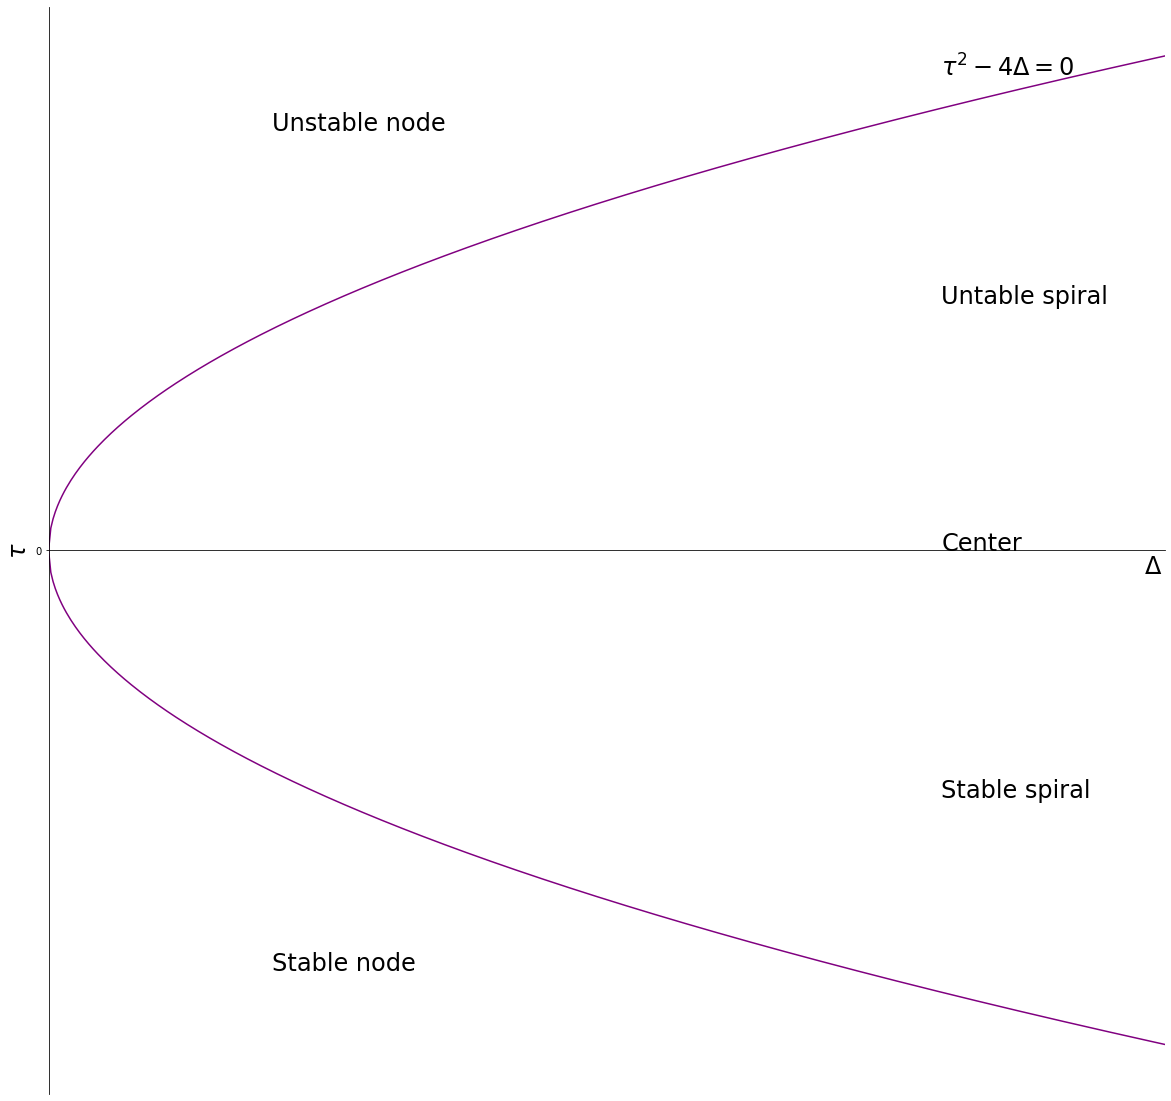

In [197]:
deltas = np.linspace(0, 1, 500)
plt.plot(deltas, 2 * np.sqrt(deltas), color='purple')
plt.plot(deltas, -2 * np.sqrt(deltas), color='purple')

plt.gca().set_xlim([0, 1])
plt.gca().spines["bottom"].set_position("zero")
plt.gca().spines["top"].set_color("none")
plt.gca().spines["right"].set_color("none")

plt.xlabel("$\Delta$", x=0.99, fontsize=24)
plt.ylabel("$\\tau$", y=0.5, fontsize=24)
plt.gca().set_xticks([])
plt.gca().set_yticks([0])

plt.text(0.8, 1.92, "$\\tau^2 - 4\Delta = 0$", fontsize=24)
plt.text(0.2, 1.7, "Unstable node", fontsize=24)
plt.text(0.2, -1.7, "Stable node", fontsize=24)
plt.text(0.8, 1, "Untable spiral", fontsize=24)
plt.text(0.8, -1, "Stable spiral", fontsize=24)
plt.text(0.8, 0, "Center", fontsize=24)

plt.show()